<a href="https://colab.research.google.com/github/arthurvaz05/Python.Script/blob/master/Grafo_RSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx

# Carregar as bibliotecas

In [48]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Carregar as bases

In [97]:
#Extrair os dataset através desse site -> https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/All_Beauty.json.gz

--2023-05-14 15:19:36--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/All_Beauty.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/x-gzip]
Saving to: ‘All_Beauty.json.gz.2’

All_Beauty.json.gz. 100%[===================>]  45.16M  25.3MB/s    in 1.8s    

2023-05-14 15:19:38 (25.3 MB/s) - ‘All_Beauty.json.gz.2’ saved [47350910/47350910]



In [98]:
#Habilitar o acesso ao meu drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
#Verificar onde o metadado se encontra no meu drive
#!ls /content/drive/MyDrive/meta_All_Beauty.json.gz

In [100]:
### carregar os dados

data_meta = []
with gzip.open('/content/drive/MyDrive/meta_All_Beauty.json.gz') as f:
    for l in f:
        data_meta.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data_meta))

# first row of the list
print(data_meta[0])

32892
{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


In [101]:
### carregar os dados

data = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [102]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)
df_meta = pd.DataFrame.from_dict(data_meta)

print(len(df))
print(len(df_meta))

371345
32892


# Tratamento das bases

In [103]:
df.loc[:,'key'] = df.reviewerID + ' ' + df.asin
df = df.loc[:,['overall','reviewerID','asin','key']]
df.drop_duplicates(inplace = True)

In [104]:
df = df.fillna('')
df_meta = df_meta.fillna('')

In [105]:
#df.head(5)

In [106]:
#df_meta.head(5)

In [107]:
#df.dtypes

In [108]:
#df_meta.dtypes

In [109]:
df.loc[:,'likes'] = df.overall.map( lambda x: 1 if x >=4 else 0)

In [110]:
df.shape

(361818, 5)

In [111]:
#selecionar apenas os usuários que fizeram mais de duas avaliações
review = pd.DataFrame(df.reviewerID.value_counts())
df = df.loc[df.reviewerID.isin(review[review.reviewerID >= 4].index),:]

In [112]:
df.shape

(8802, 5)

In [113]:
df_sample = df.sample(n=(int(np.round(len(df)*0.005,0))))

In [114]:
df_sample.shape

(44, 5)

# Grafos

In [115]:
#um outro jeito de criar as arestas
#H = nx.from_pandas_edgelist(df, 
#                            source='reviewerID', 
#                            target='asin', 
#                            create_using=nx.Graph, 
#                            edge_attr='likes')

In [116]:
G = nx.DiGraph(directed=True)
#Adicionando todos os vértices
G.add_nodes_from(pd.concat([df_sample.asin, df_sample.reviewerID], axis=0))
#Adicionando todas as arestas
G.add_edges_from(np.array(df_sample[df_sample.likes.eq(1)][['reviewerID', 'asin']]))

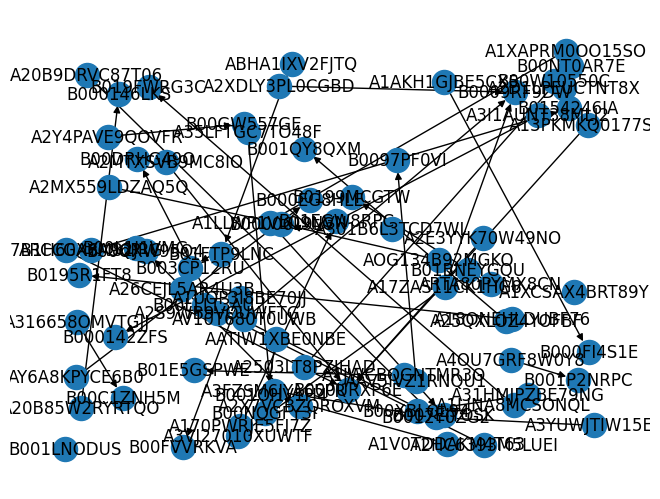

In [117]:
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels = True)

# Distâncias dos cossenos

In [118]:
#df_meta.loc[:,['asin','title']].head(5)

In [119]:
#df.head(5)

In [120]:
df = df.merge(df_meta.loc[:,['asin','title']], on='asin', how='left')
df = df.dropna()

In [122]:
df = df.drop_duplicates()

In [124]:
df = df.loc[:,['reviewerID','asin','likes','title']]

In [125]:
def create_list(x):
  return list(df.loc[df.reviewerID == x,'asin'])

In [126]:
listas = []
for i in range(len(list(df.reviewerID.drop_duplicates()))):
  j = list(df.reviewerID.drop_duplicates())[i]
  listas.append(create_list(j))

In [127]:
df2 = pd.DataFrame(df.reviewerID.drop_duplicates())

In [128]:
df2.loc[:,'Produtos_likes'] = listas

In [129]:
df2.Produtos_likes = df2.Produtos_likes.map( lambda x: ' '.join(x))

In [130]:
#df2 = pd.get_dummies(df.asin)
#df2.index = df.reviewerID
#df2


Scikit-learn's CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the ​pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [131]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df2.Produtos_likes)
#print("Count Matrix:", count_matrix.toarray())

Count Matrix: [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [132]:
cosine_sim = cosine_similarity(count_matrix)

In [135]:
df2.reset_index(inplace = True)

In [136]:
df2.drop(['index'], axis=1, inplace = True)

# Recomendação

In [138]:
#Escolha o usuário que receberá recomendação
similar_movies = list(enumerate(cosine_sim[1]))

In [139]:
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)

In [296]:
z = pd.DataFrame(sorted_similar_movies[1:4])
z.columns = ['index','semelhanca']

In [193]:
produtos = df.loc[df.reviewerID==df2.loc[z.loc[0,'index'],'reviewerID'],'title']
produtos = pd.DataFrame(produtos)
produtos.loc[:,'cossenos'] = z.loc[0,'semelhanca']
produtos.columns = ['from','semelhanca']
produtos.reset_index(inplace=True)
produtos.drop('index',inplace=True, axis = 1)
produtos2 = produtos

In [289]:
x = produtos2.loc[(0+1):len(produtos2)-1,'from']
x = pd.DataFrame(x)
x.column = 'from'
x.loc[:,'to'] = produtos2.loc[0,'from']
for i in range(1,(len(produtos2)-1)):
  #print(i)
  z = produtos2.loc[(i+1):len(produtos2)-1,'from']
  z = pd.DataFrame(z)
  z.column = 'from'
  z.loc[:,'to'] = produtos2.loc[i,'from']
  x = pd.concat([x,z], ignore_index=True)

In [291]:
x['peso'] = produtos['semelhanca'][0]

In [297]:
produtos = df.loc[df.reviewerID==df2.loc[z.loc[1,'index'],'reviewerID'],'title']
produtos = pd.DataFrame(produtos)
produtos.loc[:,'cossenos'] = z.loc[1,'semelhanca']
produtos.columns = ['from','semelhanca']
produtos.reset_index(inplace=True)
produtos.drop('index',inplace=True, axis = 1)
produtos2 = produtos

for i in range(1,(len(produtos2)-1)):
  #print(i)
  z = produtos2.loc[(i+1):len(produtos2)-1,'from']
  z = pd.DataFrame(z)
  z.column = 'from'
  z.loc[:,'to'] = produtos2.loc[i,'from']
  x = pd.concat([x,z], ignore_index=True)

In [303]:
x = x.fillna(produtos['semelhanca'][1])

In [304]:
x

,from,to,peso
0,Norelco Clean Jet Solution 10oz Cool Breeze,Braun 8000 Activator Combi-Pack Foil and Cutte...,0.50
1,Philips Norelco BG2020 BodyGroom,Braun 8000 Activator Combi-Pack Foil and Cutte...,0.50
2,Philips Norelco 1050CC arcitec Men's Shaving S...,Braun 8000 Activator Combi-Pack Foil and Cutte...,0.50
3,Philips Norelco BG2020 BodyGroom,Norelco Clean Jet Solution 10oz Cool Breeze,0.50
4,Philips Norelco 1050CC arcitec Men's Shaving S...,Norelco Clean Jet Solution 10oz Cool Breeze,0.50
5,Philips Norelco 1050CC arcitec Men's Shaving S...,Philips Norelco BG2020 BodyGroom,0.50
6,Sol De Janeiro Brazilian Crush Body Fragrance ...,"Avalon Organics Vitamin C Renewal Creme, 2 oz",0.25
7,Hesh Rose petal powder Herbal 100gms,"Avalon Organics Vitamin C Renewal Creme, 2 oz",0.25
8,Hesh Rose petal powder Herbal 100gms,Sol De Janeiro Brazilian Crush Body Fragrance ...,0.25


In [286]:
del  x

In [287]:
del z